<a href="https://colab.research.google.com/github/Hydenx2004/Image-Search-Tool/blob/main/ImageSearchTool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchvision Pillow faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 27.5 MB/s eta 0:00:00


In [2]:
import torch
from torchvision import models, transforms
from PIL import Image
import os
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from tqdm import tqdm
import faiss

In [3]:
class ImageRAG:
    def __init__(self):
        # Load ResNet50 and modify it to output features from the avgpool layer
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.model = torch.nn.Sequential(*list(self.model.children())[:-1])  # Remove the final classification layer
        self.model.eval()
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.image_paths = []
        self.index = None
        self.dimension = 2048  # ResNet-50's avgpool layer output dimension

    def extract_features(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image).unsqueeze(0)
        with torch.no_grad():
            features = self.model(image)
        return features.numpy().flatten()

    def build_index(self, image_folder):
        features = []
        for image_name in tqdm(os.listdir(image_folder)):
            if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(image_folder, image_name)
                feature = self.extract_features(image_path)
                features.append(feature)
                self.image_paths.append(image_path)

        features = np.array(features, dtype='float32')

        # Create a FAISS index
        self.index = faiss.IndexFlatL2(self.dimension)
        self.index.add(features)

    def search(self, query_image_path, k=5):
        query_feature = self.extract_features(query_image_path).reshape(1, -1).astype('float32')
        distances, indices = self.index.search(query_feature, k)
        results = [self.image_paths[i] for i in indices[0]]

        # Remove the query image if it's mistakenly included in the results
        results = [result for result in results if result != query_image_path]

        return results[:k]  # Ensure we still return k results


In [4]:
!mkdir -p database_images

In [5]:
uploaded = files.upload()
for filename in uploaded.keys():
    !mv "{filename}" database_images/

Saving db_image1.jpg to db_image1.jpg
Saving db_image2.jpg to db_image2.jpg
Saving db_image3.jpg to db_image3.jpg
Saving db_image4.jpg to db_image4.jpg
Saving db_image9.jpg to db_image9.jpg
Saving db_image10.jpg to db_image10.jpg
Saving db_image11.jpg to db_image11.jpg
Saving db_image12.jpg to db_image12.jpg
Saving muk2.jpg to muk2.jpg
Saving muk3.jpg to muk3.jpg
Saving muk4.jpg to muk4.jpg


In [6]:
uploaded = files.upload()
for filename in uploaded.keys():
    !mv "{filename}" database_images/

Saving muk1.jpg to muk1.jpg


In [7]:
rag = ImageRAG()
print("Building index...")
rag.build_index('database_images')
print("Index built successfully!")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 118MB/s]


Building index...


100%|██████████| 12/12 [00:05<00:00,  2.29it/s]

Index built successfully!


In [9]:
query_image_path = 'database_images/muk1.jpg'  # Update this line with the correct image name

# Perform the search and display the results
print(f"Searching for images similar to: {query_image_path}")
results = rag.search(query_image_path, k=4)

Searching for images similar to: database_images/muk1.jpg



Top 3 similar images:


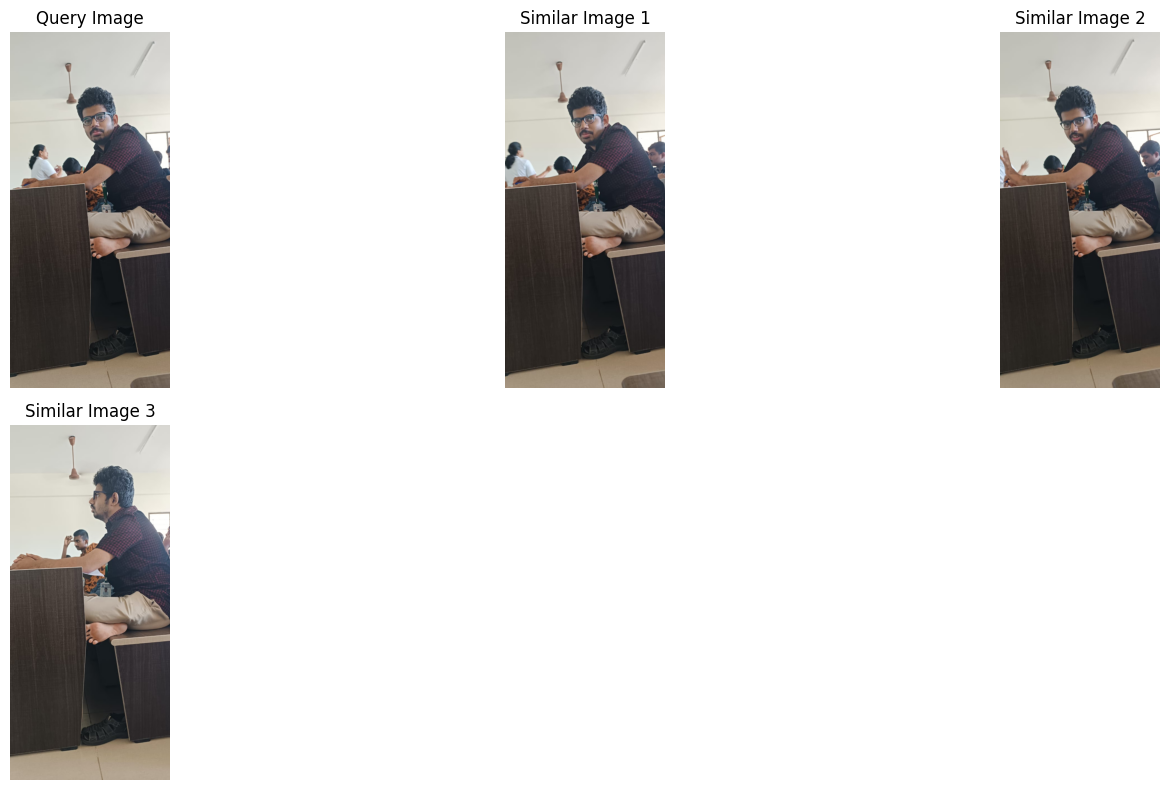

In [10]:
def display_images(query_image, similar_images):
    plt.figure(figsize=(15, 8))

    # Display query image
    plt.subplot(2, 3, 1)
    plt.imshow(Image.open(query_image))
    plt.title("Query Image")
    plt.axis('off')

    # Display similar images
    for i, img_path in enumerate(similar_images, start=2):
        plt.subplot(2, 3, i)
        plt.imshow(Image.open(img_path))
        plt.title(f"Similar Image {i-1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\nTop 3 similar images:")

# Display the query and similar images
display_images(query_image_path, results)